# Chapter 13: GPU-Accelerated Ising Model Simulation in NVIDIA Warp

## Overview

In Chapter 12, we introduced NVIDIA Warp as a framework for writing high-performance GPU code in Python. We explored its fundamental concepts: the kernel-based programming model, data structures like arrays and built-in types, and the just-in-time compilation process that enables near-native performance.

In this chapter, we will apply these concepts to implement a classic physics simulation: the 2D Ising model. This serves as an excellent case study for GPU acceleration because:

1. **Inherent Parallelism**: Each lattice site can potentially be updated independently
2. **Memory Access Patterns**: Requires careful consideration of neighbor interactions
3. **Real-World Relevance**: The Ising model is fundamental in statistical physics, materials science, etc.

Through this implementation, you'll learn:

* How to translate a sequential algorithm into a parallel GPU kernel
* Common pitfalls when parallelizing algorithms with neighbor dependencies
* The checkerboard decomposition pattern for avoiding race conditions
* Performance optimization techniques specific to GPU architectures
* How to visualize and analyze simulation results

By the end of this chapter, you'll have a GPU-accelerated Ising model simulation that runs orders of magnitude faster than its CPU counterpart, while gaining practical experience in applying Warp's features to solve real computational physics problems.

---


## Setup

Before we begin implementing the Ising model, let's ensure we have all the necessary packages installed.

First, we'll install NVIDIA Warp if it's not already available:


In [1]:
# Install NVIDIA Warp
%pip install warp-lang

# Install visualization dependencies
%pip install matplotlib ipympl Pillow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Now let's import the necessary libraries and initialize Warp to ensure GPU support is available:


In [2]:
# Core imports
import numpy as np
import warp as wp

# Initialize Warp and verify GPU is available
wp.init()

# Check for GPU availability
devices = wp.get_devices()
if "cuda:0" not in [d.alias for d in devices]:
    raise RuntimeError("No GPU detected! This notebook requires an NVIDIA GPU.")
else:
    print("✓ GPU detected successfully")
    gpu_device = wp.get_device("cuda:0")
    print(f"  Device: {gpu_device.name}")
    print(f"  Compute capability: {gpu_device.arch}")
    print(f"  Memory: {gpu_device.total_memory / (1024**3):.1f} GB")


Warp 1.8.0 initialized:
   CUDA Toolkit 12.8, Driver 12.8
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA RTX 5000 Ada Generation Laptop GPU" (16 GiB, sm_89, mempool enabled)
   Kernel cache:
     /home/snidhan/.cache/warp/1.8.0
✓ GPU detected successfully
  Device: NVIDIA RTX 5000 Ada Generation Laptop GPU
  Compute capability: 89
  Memory: 15.6 GB


---

## Introduction: From Warp Fundamentals to Real-World Applications

In Chapter 12, we learned the essential building blocks of NVIDIA Warp:

1. **Kernels**: Functions decorated with `@wp.kernel` that run in parallel across many threads
2. **Arrays**: The fundamental data structure for GPU computation
3. **Built-in Types**: Efficient vector and matrix types like `wp.vec3` and `wp.mat44`
4. **Launch Configurations**: How to control kernel execution with `wp.launch()`
5. **Memory Spaces**: Understanding CPU vs. GPU memory and data transfers

Now, we'll apply these concepts to implement a classic computational physics problem: the 2D Ising model. This implementation will demonstrate:

- **Kernel Design Patterns**: How to structure kernels for algorithms with neighbor dependencies
- **Memory Access Optimization**: Efficient patterns for reading and writing shared data
- **Synchronization Strategies**: Avoiding race conditions in parallel updates
- **Performance Analysis**: Comparing GPU vs. CPU implementations

The Ising model is particularly instructive because it highlights both the power and challenges of GPU parallelization. While the algorithm seems embarrassingly parallel at first glance (each lattice site can be updated independently), the devil is in the details—neighboring sites interact, creating potential race conditions that must be carefully managed.

Let's begin by understanding the physics behind the Ising model, then progressively build our GPU implementation, learning from common pitfalls along the way.

---

## Background: The Ising Model in Statistical Physics

### What is the Ising Model?

The [Ising model](https://en.wikipedia.org/wiki/Ising_model) serves as a fundamental framework for understanding **phase transitions** and **critical phenomena**. Named after physicist Ernst Ising, this model captures the essential physics of ferromagnetism while being simple enough to simulate and analyze computationally.

### Physical Setup

Imagine a two-dimensional grid where each site contains a **magnetic spin** that can point either "up" (↑) or "down" (↓). In mathematical terms, each spin $\sigma_i$ takes the value $+1$ (up) or $-1$ (down). This seemingly simple setup gives rise to remarkably rich physics:

- At **low temperatures**: Spins tend to align with their neighbors, creating ordered regions
- At **high temperatures**: Thermal fluctuations dominate, leading to random, disordered spin configurations
- At the **critical temperature**: The system undergoes a dramatic phase transition

### The Physics: Energy and Interactions

The total energy of the system is governed by the **Hamiltonian**:

\begin{equation}
H(\sigma) = - J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
\end{equation}

Let's break this down:
- **$\sum_{\langle i,j \rangle}$**: Sum over all pairs of nearest neighbors (4 neighbors per site in 2D)
- **$J > 0$**: Interaction strength (we will set $J = 1$ for simplicity)  
- **$\sigma_i \sigma_j$**: Product of neighboring spins

The key insight is in the **negative sign**:
- When neighboring spins are **aligned** ($\sigma_i = \sigma_j$): $\sigma_i \sigma_j = +1 \Rightarrow$ energy contribution is $-J$ (lower energy, preferred)
- When neighboring spins are **anti-aligned** ($\sigma_i \neq \sigma_j$): $\sigma_i \sigma_j = -1 \Rightarrow$ energy contribution is $+J$ (higher energy, unfavorable)

This creates a natural tendency for spins to align with their neighbors.

### The Battle: Order vs. Disorder

The Ising model beautifully captures the competition between two fundamental forces:

1. **Energy Minimization** (favors order): Spins want to align to minimize the Hamiltonian
2. **Entropy Maximization** (favors disorder): Thermal fluctuations randomize spin orientations

The **temperature** $T$ determines which force wins:
- **$T \ll T_c$**: Energy wins → ordered ferromagnetic state
- **$T \gg T_c$**: Entropy wins → disordered paramagnetic state  
- **$T \approx T_c$**: Critical behavior with scale-invariant fluctuations

### Simulation Algorithm: Metropolis-Hastings Method

To simulate this system computationally, we use the [**Metropolis-Hastings algorithm**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm), which samples configurations according to the **Boltzmann distribution**:

$$P(\sigma) \propto e^{-H(\sigma)/(k_B T)}$$

#### Algorithm Steps

Starting from an initial configuration, we iterate the following process:

1. **Selection**: Randomly choose a lattice site $i$
2. **Proposal**: Consider flipping the spin $\sigma_i \rightarrow -\sigma_i$
3. **Energy Change**: Calculate $\Delta E =$ (energy after flip) - (energy before flip)
4. **Accept/Reject Decision**:
   - If $\Delta E \leq 0$: **Accept** the flip (lower energy is always favorable)
   - If $\Delta E > 0$: **Accept** with probability $P_{accept} = e^{-\Delta E/(k_B T)}$
5. **Update**: Apply the flip if accepted, otherwise keep the original spin

#### Why This Works

The acceptance probability $e^{-\Delta E/(k_B T)}$ ensures that:
- **Low temperatures**: Only energy-lowering moves are likely to be accepted
- **High temperatures**: Even energy-raising moves have significant acceptance probability
- **Detailed balance**: The algorithm converges to the correct equilibrium distribution

### Computational Significance

While the 2D Ising model has known analytical solutions, it serves as an excellent computational testbed because:

- **Algorithmic complexity**: The Metropolis algorithm involves neighbor interactions and probabilistic updates
- **Parallelization challenges**: Naive parallelization leads to race conditions when updating neighboring spins simultaneously
- **Performance optimization**: Memory access patterns and GPU parallelization strategies can be explored
- **Scalability**: Real-world applications often involve millions or billions of spins

In the next sections, we'll implement this model firs in Numpy and then in NVIDIA Warp -- progressively building from a naive parallel approach to an optimized GPU implementation that avoids race conditions through clever algorithmic design.

---

## A Basic Python Implementation

Before diving into GPU acceleration with Warp, let's implement a reference version in pure Python. This serves multiple purposes:

1. **Algorithm Verification**: Ensures our understanding of the Metropolis-Hastings algorithm is correct
2. **Performance Baseline**: Provides a comparison point for measuring GPU speedup
3. **Debugging Reference**: A simple implementation to validate against more complex GPU code

### Implementation Strategy

Our Python implementation follows the standard Metropolis-Hastings algorithm:

- **Random Site Selection**: Instead of scanning sites in order, we randomly shuffle the update sequence to avoid artifacts
- **Periodic Boundary Conditions**: The lattice wraps around at edges
- **Energy-Based Acceptance**: We use the full Boltzmann acceptance probability $P = e^{-\Delta E / T}$

### Performance Limitations

Since this is a pure Python implementation with nested loops and random number generation, we're restricted to relatively small lattice sizes (≤ 512×512) for reasonable simulation times. The GPU implementation will dramatically improve this.

In [3]:
import random
import math


def initialize_lattice(L):
    """
    Initialize a square lattice with random spin orientations.
    
    Creates an L×L grid where each site contains a magnetic spin that can be
    either +1 (spin up) or -1 (spin down). The initial configuration is
    completely random, representing a high-temperature disordered state.
    
    Args:
        L (int): Linear size of the lattice (creates L×L grid)
        
    Returns:
        list[list[int]]: 2D lattice where lattice[i][j] ∈ {-1, +1}
        
    Example:
        >>> lattice = initialize_lattice(4)
        >>> print(len(lattice), len(lattice[0]))  # 4x4 grid
        4 4
        >>> all(spin in [-1, 1] for row in lattice for spin in row)
        True
    """
    lattice = [[random.choice([-1, 1]) for _ in range(L)] for _ in range(L)]
    return lattice


def monte_carlo_step(lattice, L, T):
    """
    Perform one complete Monte Carlo step using the Metropolis-Hastings algorithm.
    
    A Monte Carlo step (MCS) consists of attempting to flip each spin in the 
    lattice exactly once on average. We visit sites in random order to avoid
    systematic biases that could arise from sequential scanning.
    
    For each site, we calculate the energy change ΔE that would result from
    flipping the spin, then accept or reject the flip based on the Boltzmann
    probability: P_accept = min(1, exp(-ΔE/T))
    
    Physical Parameters (using natural units):
        - J = 1: Interaction strength (energy scale)
        - k_B = 1: Boltzmann constant
        - Periodic boundary conditions (toroidal lattice)
    
    Args:
        lattice (list[list[int]]): Current spin configuration to update in-place
        L (int): Linear lattice size 
        T (float): Temperature in units where k_B = J = 1
                   T_critical ≈ 2.269 for 2D Ising model
    
    Algorithm Details:
        1. Create list of all (i,j) lattice coordinates
        2. Randomly shuffle the update order to avoid artifacts
        3. For each site (i,j):
           a. Calculate sum of 4 nearest neighbors using periodic boundaries
           b. Compute energy change: ΔE = 2 * J * σ_ij * Σ_neighbors  
           c. Accept flip with probability P = exp(-ΔE/T)
           d. Update lattice[i][j] *= -1 if flip accepted
    
    Note:
        The acceptance ratio simplifies to exp(-2 * β * σ_ij * neighbor_sum)
        because we only consider the energy difference, not absolute energy.
    """
    # Convert temperature to inverse temperature (β = 1/T in natural units)
    beta = 1.0 / T

    # Generate all lattice coordinates and randomize update order
    # This prevents systematic artifacts from sequential scanning
    site_indices = [(r_idx, c_idx) for r_idx in range(L) for c_idx in range(L)]
    random.shuffle(site_indices)

    # Attempt to flip each spin according to Metropolis acceptance criterion
    for i, j in site_indices:
        # Current spin at site (i,j)
        spin_ij = lattice[i][j]

        # Calculate sum of 4 nearest neighbors with periodic boundary conditions
        # Modulo arithmetic wraps around lattice edges: (i-1+L)%L handles i=0 case
        nn_sum = (
            lattice[(i - 1 + L) % L][j]      # neighbor above
            + lattice[(i + 1) % L][j]        # neighbor below  
            + lattice[i][(j - 1 + L) % L]    # neighbor left
            + lattice[i][(j + 1) % L]        # neighbor right
        )

        # Energy change from flipping spin: ΔE = -J * (σ_new - σ_old) * Σ_neighbors
        # Since σ_new = -σ_old, we get: ΔE = 2 * J * σ_ij * Σ_neighbors
        # Acceptance probability: P = exp(-β * ΔE) = exp(-2 * β * σ_ij * Σ_neighbors)
        acceptance_ratio = math.exp(-2.0 * beta * spin_ij * nn_sum)

        # Accept flip if random number < acceptance probability
        if random.random() < acceptance_ratio:
            lattice[i][j] *= -1  # Flip the spin: +1 → -1 or -1 → +1
        # If flip rejected, spin remains unchanged (no action needed)

Simulating 256×256 Ising model at T=1.0
Critical temperature T_c ≈ 2.269 (this run: below T_c)
Running simulation and capturing frames...
  Step 50/200 completed
  Step 100/200 completed
  Step 150/200 completed
  Step 200/200 completed
Simulation completed in 4.97 seconds
Creating animated GIF...


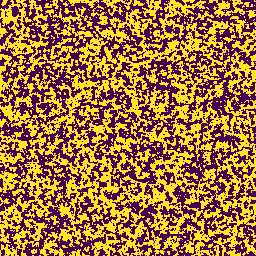

In [4]:
%matplotlib widget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

import random
import math
import os
import time

# ================================
# Demonstration 1: Visual Evolution
# ================================
"""
This demonstration shows the real-time evolution of the Ising model as an animated GIF.
We'll observe how the system evolves from a random initial state toward equilibrium.

Key observations to look for:
- Domain formation: Regions of aligned spins (same color) will grow
- Thermal fluctuations: At finite temperature, domains constantly change
- Steady state: Eventually the system reaches dynamic equilibrium
"""

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 1.0 # Try: T=1.0 (ordered), T=2.269 (critical), T=5.0 (disordered)

print(f"Simulating {LATTICE_SIZE}×{LATTICE_SIZE} Ising model at T={TEMPERATURE}")
print(f"Critical temperature T_c ≈ 2.269 (this run: {'below' if TEMPERATURE < 2.269 else 'above'} T_c)")

# Initialize with random spins (mimics infinite temperature initial condition)
lattice = initialize_lattice(LATTICE_SIZE)

# Set up visualization colormap
# Viridis colormap: dark blue (-1 spins) to bright yellow (+1 spins)
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect animation frames
frames = []
print("Running simulation and capturing frames...")

start_time = time.perf_counter()
for step in range(200):  # 200 Monte Carlo steps
    # Evolve the system by one complete lattice sweep
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)

    # Convert lattice to colored image for visualization
    # Each spin value (-1 or +1) gets mapped to a color
    colored_frame = viridis(norm(np.array(lattice)))

    # Convert to 8-bit RGB for GIF creation
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

    # Progress indicator
    if (step + 1) % 50 == 0:
        print(f"  Step {step + 1}/200 completed")

end_time = time.perf_counter()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")

# Create animated GIF to visualize time evolution
print("Creating animated GIF...")
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"output/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

# Save as animated GIF (100ms per frame = 10 FPS)
pil_images[0].save(
    output_filename, 
    save_all=True, 
    append_images=pil_images[1:], 
    duration=100,  # milliseconds per frame
    loop=0         # infinite loop
)

IPython.display.Image(output_filename)


Magnetization analysis: 256×256 lattice at T=1.0
Running magnetization tracking simulation...
  Step 100/500, Current M = -0.020
  Step 200/500, Current M = 0.032
  Step 300/500, Current M = 0.079
  Step 400/500, Current M = 0.158
  Step 500/500, Current M = 0.226


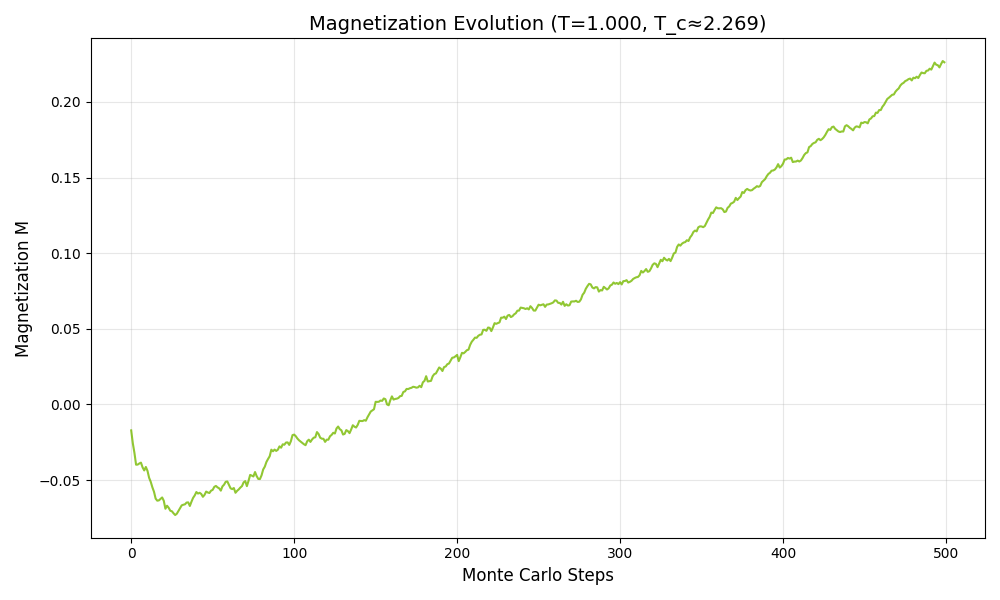

In [5]:
# =======================================
# Demonstration 2: Magnetization Analysis
# =======================================
"""
This demonstration tracks the magnetization over time to study thermodynamic properties.
Magnetization M = ⟨Σᵢ σᵢ⟩ / N is the order parameter for the ferromagnetic transition.

Physical meaning:
- M ≈ ±1: Ordered state (most spins aligned)
- M ≈ 0: Disordered state (equal up/down spins)
- |M| decreases as T approaches T_c from below
"""

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 1.0 # Try: T=1.0 (ordered), T=2.269 (critical), T=5.0 (disordered)

print(f"Magnetization analysis: {LATTICE_SIZE}×{LATTICE_SIZE} lattice at T={TEMPERATURE}")

# Initialize with random configuration
lattice = initialize_lattice(LATTICE_SIZE)
magnetization_values = []


def calculate_magnetization(lattice, L):
    """
    Calculate the normalized magnetization of the lattice.
    
    The magnetization M is the order parameter for the ferromagnetic phase transition.
    It measures the degree of spin alignment in the system.
    
    Args:
        lattice (list[list[int]]): Current spin configuration
        L (int): Linear lattice size
        
    Returns:
        float: Normalized magnetization M ∈ [-1, +1]
               M = +1: All spins up (perfect ferromagnetic order)
               M = -1: All spins down (perfect ferromagnetic order)  
               M = 0: Equal numbers of up/down spins (disordered)
    
    Physics Notes:
        - M is the thermal average ⟨Σᵢ σᵢ⟩ / N in equilibrium
        - |M| → 0 as T → T_c from below (continuous phase transition)
        - M fluctuates around its equilibrium value due to thermal noise
    """
    total_spin = sum(sum(row) for row in lattice)
    return total_spin / (L * L)


# Run simulation and track magnetization evolution
print("Running magnetization tracking simulation...")
for step in range(500):
    monte_carlo_step(lattice, LATTICE_SIZE, TEMPERATURE)
    current_mag = calculate_magnetization(lattice, LATTICE_SIZE)
    magnetization_values.append(current_mag)
    
    # Progress update
    if (step + 1) % 100 == 0:
        print(f"  Step {step + 1}/500, Current M = {current_mag:.3f}")

# Create magnetization time series plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(magnetization_values, "-", linewidth=1.5, color="#76b900", alpha=0.8)

ax.set_xlabel("Monte Carlo Steps", fontsize=12)
ax.set_ylabel("Magnetization M", fontsize=12)
ax.set_title(f"Magnetization Evolution (T={TEMPERATURE:.3f}, T_c≈2.269)", fontsize=14)
ax.grid(True, alpha=0.3)


fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.resizable = False

plt.tight_layout()

--- 
## GPU Implementation Part 1: Naive Parallelization Approach

Now that we have established our baseline CPU implementation, let's leverage NVIDIA Warp to accelerate our simulation.

### Parallel Monte Carlo Strategy

Our first approach uses a straightforward parallelization strategy:

1. Launch a GPU kernel across a $N \times N$ grid where each thread processes one lattice site
2. Use a double-buffer approach to avoid race conditions:
   - `lattice_0`: Contains the current state (read-only during update)
   - `lattice_1`: Stores the updated state after parallel processing

### Core Update Logic

The core update logic would then look something like this

```python
def parallel_update_site(i, j, lattice_0, lattice_1, L, beta):
    # Read current spin value
    spin_ij = lattice_0[i, j]
    
    # Calculate nearest neighbor sum with periodic boundary conditions
    # from lattice_0
    nn_sum = (
        lattice_0[(i - 1 + L) % L, j] +      # Top neighbor
        lattice_0[(i + 1) % L, j] +          # Bottom neighbor  
        lattice_0[i, (j - 1 + L) % L] +      # Left neighbor
        lattice_0[i, (j + 1) % L]            # Right neighbor
    )
    
    # Calculate acceptance probability using Metropolis criterion
    acceptance_probability = wp.exp(-2.0 * beta * spin_ij * nn_sum)
    
    # Generate random number and decide whether to flip
    if wp.randf() < acceptance_probability:
        lattice_1[i, j] = -lattice_0[i, j]     # Flip the spin and save to lattice_1
```

Let's implement this approach and examine its performance characteristics...

### GPU Memory Allocation

To implement this on the GPU, we need to allocate storage for our lattice data structure. We will use a 2D Warp array to store the spin configuration. We use `wp.int8` as our data type since each spin only needs to store values of +1 or -1, making this the most memory-efficient choice.

### Random Number Generation in Warp

For the Monte Carlo acceptance decisions, each GPU thread needs to generate independent random numbers. Warp provides a built-in random number generator that can be called directly from within kernels.

The key components of Warp's RNG system are:

1. **Initialization**: Create an RNG state using `wp.rand_init(seed, offset)`
   - `seed`: Common value shared across all threads (ensures reproducibility)
   - `offset`: Unique value per thread (ensures uncorrelated sequences)

2. **Generation**: Use `wp.randf(state)` to generate random floats in [0,1)

This approach ensures that:
- Each thread generates independent random numbers
- The simulation is reproducible when using the same seed
- Random number generation happens efficiently on the GPU without CPU-GPU transfers

Now let's implement the complete solution...

In [6]:
import warp as wp

# ==============================================
# Direct Parallelization Implementation
# ==============================================

# Define lattice dimensions - using 256x256 for demonstration
# Larger sizes will showcase GPU acceleration benefits more clearly
LATTICE_SIZE = 256

# Allocate GPU memory for the spin lattice
# wp.int8 stores values -1 and +1 efficiently (1 byte per spin)
# wp.empty() allocates uninitialized memory on the default device (GPU)
lattice = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

@wp.kernel
def generate_lattice(lattice: wp.array2d(dtype=wp.int8), rng_seed: int):
    """
    GPU kernel to initialize the lattice with random spin configurations.
    
    Each GPU thread handles one lattice site, generating a random spin value.
    This demonstrates Warp's parallel random number generation capabilities.
    
    Args:
        lattice: 2D array to fill with random spins (+1 or -1)
        rng_seed: Seed for reproducible random number generation
    
    Kernel Launch:
        wp.launch(generate_lattice, dim=(LATTICE_SIZE, LATTICE_SIZE), ...)
        Creates LATTICE_SIZE² threads, one per lattice site
    """
    # Get this thread's 2D coordinates within the lattice
    # wp.tid() returns (i, j) where i∈[0,LATTICE_SIZE), j∈[0,LATTICE_SIZE)
    i, j = wp.tid()

    # Initialize random number generator state for this specific thread
    # - rng_seed: Shared across all threads for reproducible simulations
    # - offset: Unique per thread to ensure independent random sequences
    # - Linear indexing: thread (i,j) gets offset = i*width + j
    thread_offset = i * lattice.shape[1] + j
    rng_state = wp.rand_init(rng_seed, thread_offset)
    
    # Generate random spin value: +1 or -1 with equal probability
    # wp.randf() produces uniform random float in [0.0, 1.0)
    # 50% probability for each spin direction
    random_value = wp.randf(rng_state, 0.0, 1.0)
    if random_value < 0.5:
        lattice[i, j] = wp.int8(1)   # Spin up
    else:
        lattice[i, j] = wp.int8(-1)  # Spin down

Module __main__ d33af4c load on device 'cuda:0' took 0.96 ms  (cached)


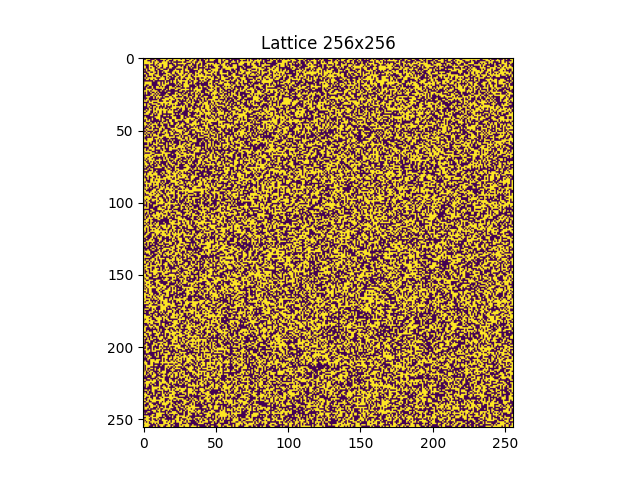

In [7]:
import matplotlib.pyplot as plt

wp.launch(generate_lattice, lattice.shape, inputs=[lattice, 42])

fig = plt.figure()
plt.imshow(lattice.numpy(), cmap="viridis")
plt.title(f"Lattice {LATTICE_SIZE}x{LATTICE_SIZE}")
plt.show()

### Implementing the Monte Carlo Update Kernel on GPU

Now we'll implement the core of our GPU-accelerated Ising model simulation: a Warp kernel that performs the Metropolis-Hastings algorithm across the entire lattice in parallel.

#### Kernel Input Parameters

Our `update_lattice` kernel requires four key inputs:

1. **`lattice_in`**: The 2D spin configuration array that serves as input
2. **`lattice_out`**: The 2D spin configuration array that serves as output and will be modified in place
3. **`rng_seed`**: Random number seed for generating acceptance probabilities  
4. **`beta`**: Inverse temperature $\beta = 1/(k_B T)$

#### Parallel Execution Strategy

Each GPU thread will:
1. Calculate the energy change $\Delta E$ from flipping its assigned spin
2. Compute the acceptance ratio
3. Generate a random number and accept/reject the flip accordingly
4. Update the lattice site in **lattice_out** array

This massively parallel approach allows us to evaluate $N^2$ spin flip proposals simultaneously, achieving speedups over sequential CPU implementations that you will see in a bit.

In [8]:
@wp.kernel
def update_lattice(
    beta: float,
    rng_seed: int,
    lattice_in: wp.array2d(dtype=wp.int8),
    lattice_out: wp.array2d(dtype=wp.int8),
):
    i, j = wp.tid()

    # Neighbors: top, bottom, left, right
    nn_sum = (
        lattice_in[(i - 1 + LATTICE_SIZE) % LATTICE_SIZE, j]
        + lattice_in[(i + 1) % LATTICE_SIZE, j]
        + lattice_in[i, (j - 1 + LATTICE_SIZE) % LATTICE_SIZE]
        + lattice_in[i, (j + 1) % LATTICE_SIZE]
    )

    # Determine whether to flip spin
    spin_ij = lattice_in[i, j]
    acceptance_ratio = wp.exp(-2.0 * beta * wp.float32(nn_sum) * wp.float32(spin_ij))

    # Generate random number between [0.0, 1.0).
    rng_state = wp.rand_init(rng_seed, i * LATTICE_SIZE + j)

    if wp.randf(rng_state, 0.0, 1.0) < acceptance_ratio:
        lattice_out[i, j] = -spin_ij
    else:
        lattice_out[i, j] = spin_ij

### Performance Analysis: First Results

Now let's examine the performance and behavior of our direct parallelization approach. The implementation we've created closely mirrors our earlier CPU-based Python version, with the key difference being the use of Warp kernels for GPU acceleration.

#### Performance Gains: The Promise of Parallelization

Running the same lattice size and number of Monte Carlo steps reveals dramatic performance improvements:

- **CPU Implementation**: ~5.0 seconds for 200 Monte Carlo steps on a 256×256 lattice
- **GPU Implementation**: ~0.1-0.2 seconds for the same workload

This represents a **25-50× speedup** - a remarkable improvement that demonstrates the power of GPU parallelization for Monte Carlo simulations. The acceleration comes from processing all 65,536 lattice sites simultaneously rather than sequentially.

#### Unexpected Results: A Physics Puzzle

However, careful examination of the simulation results at T = 1.0 reveals something concerning. At this low temperature, the 2D Ising model should exhibit strong ferromagnetic ordering - we should see large domains of aligned spins with well-defined boundaries.

Instead, the lattice configuration appears unusually fragmented and disordered. This unexpected behavior suggests that our seemingly straightforward parallelization approach may have introduced subtle but significant algorithmic issues.

#### Investigating the Discrepancy

The dramatic speedup is certainly encouraging, but the incorrect physics behavior indicates that raw performance gains mean nothing if the underlying algorithm produces wrong results. This observation leads us to an important question:

**What could be causing this discrepancy between expected and observed behavior?**


Module __main__ aaf2dc8 load on device 'cuda:0' took 0.34 ms  (cached)
Simulating 256×256 Ising model at T=1.0
Critical temperature T_c ≈ 2.269 (this run: below T_c)
Running simulation and capturing frames...
  Step 50/200 completed
  Step 100/200 completed
  Step 150/200 completed
  Step 200/200 completed
Simulation completed in 0.20 seconds
Creating animated GIF...


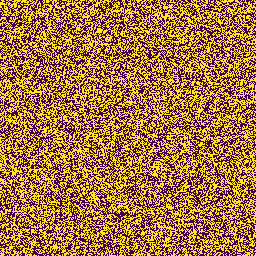

In [9]:
%matplotlib widget

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import IPython.display

import random
import math
import os
import time

# ================================
# Demonstration 1: Visual Evolution
# ================================
"""
This demonstration shows the real-time evolution of the Ising model as an animated GIF.
We'll observe how the system evolves from a random initial state toward equilibrium.

Key observations to look for:
- Domain formation: Regions of aligned spins (same color) will grow
- Thermal fluctuations: At finite temperature, domains constantly change
- Steady state: Eventually the system reaches dynamic equilibrium
"""

# --- Simulation Parameters ---
LATTICE_SIZE = 256
TEMPERATURE = 1.0 # Try: T=1.0 (ordered), T=2.269 (critical), T=5.0 (disordered)


#--- Warp related initializations/declarations ---
BETA = 1.0 / TEMPERATURE
lattice_0 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)
lattice_1 = wp.empty((LATTICE_SIZE, LATTICE_SIZE), dtype=wp.int8)

wp.launch(generate_lattice, lattice_0.shape, inputs=[lattice_0, 42])

print(f"Simulating {LATTICE_SIZE}×{LATTICE_SIZE} Ising model at T={TEMPERATURE}")
print(f"Critical temperature T_c ≈ 2.269 (this run: {'below' if TEMPERATURE < 2.269 else 'above'} T_c)")

# Set up visualization colormap
# Viridis colormap: dark blue (-1 spins) to bright yellow (+1 spins)
viridis = plt.cm.viridis
norm = Normalize(vmin=-1, vmax=1)

# Collect animation frames
frames = []
print("Running simulation and capturing frames...")

start_time = time.perf_counter()
for step in range(200):  # 200 Monte Carlo steps
    # Warp kernel call that updates the lattice
    wp.launch(update_lattice, lattice.shape, inputs=[BETA, step, lattice_0, lattice_1])
    lattice_0, lattice_1 = lattice_1, lattice_0

    # Convert lattice to colored image for visualization
    # Each spin value (-1 or +1) gets mapped to a color
    colored_frame = viridis(norm(np.array(lattice_1.numpy())))

    # Convert to 8-bit RGB for GIF creation
    rgb_frame = (colored_frame[:, :, :3] * 255).astype(np.uint8)
    frames.append(rgb_frame)

    # Progress indicator
    if (step + 1) % 50 == 0:
        print(f"  Step {step + 1}/200 completed")

end_time = time.perf_counter()
print(f"Simulation completed in {end_time - start_time:.2f} seconds")

# Create animated GIF to visualize time evolution
print("Creating animated GIF...")
pil_images = [Image.fromarray(frame, mode="RGB") for frame in frames]
output_filename = f"output/{LATTICE_SIZE}x{LATTICE_SIZE}_{TEMPERATURE}.gif"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_filename), exist_ok=True)

# Save as animated GIF (100ms per frame = 10 FPS)
pil_images[0].save(
    output_filename, 
    save_all=True, 
    append_images=pil_images[1:], 
    duration=100,  # milliseconds per frame
    loop=0         # infinite loop
)

IPython.display.Image(output_filename)

---

## GPU Implementation Part 2: Checkerboard Approach

The issue with the previous approach is that multiple threads are reading and writing to the shared data in an uncoordinated way. If you remember the baseline Python implementation, the subsequenct at different site_indices can have dependency on the new values of lattice points